## Classification de données de sonar-mines vs rochers.

 L'objectif de ce projet est de classifier de données de signaux de sonor, afin de savoir s'ils proviennent d'un Rocher ou Mine.


In [48]:
from IPython.display import Image



# Modélisation du probleme de classification avec la méthode de la descente gradient stochastique


### 1. perceptron 

Le perceptron est un algorithme d'apprentissage de classification binaire. C'est le modèle le plus simple de réseau de neurone. A une donnée d'entrée $x= (x_1,\dots,x_d)$ il opère une combinaison linaire avec des poids. Si cette dernière valeur est supérieur à un seuil, le neurone s'active et renvoie 1, sinon un 0. Cette activation se fait en fonction de la classe d'appartenance de $x$. On peut considérer que le neurone renvoie 1 ou -1, ce qui permet une interprétation géométrique intuitive de la classification 


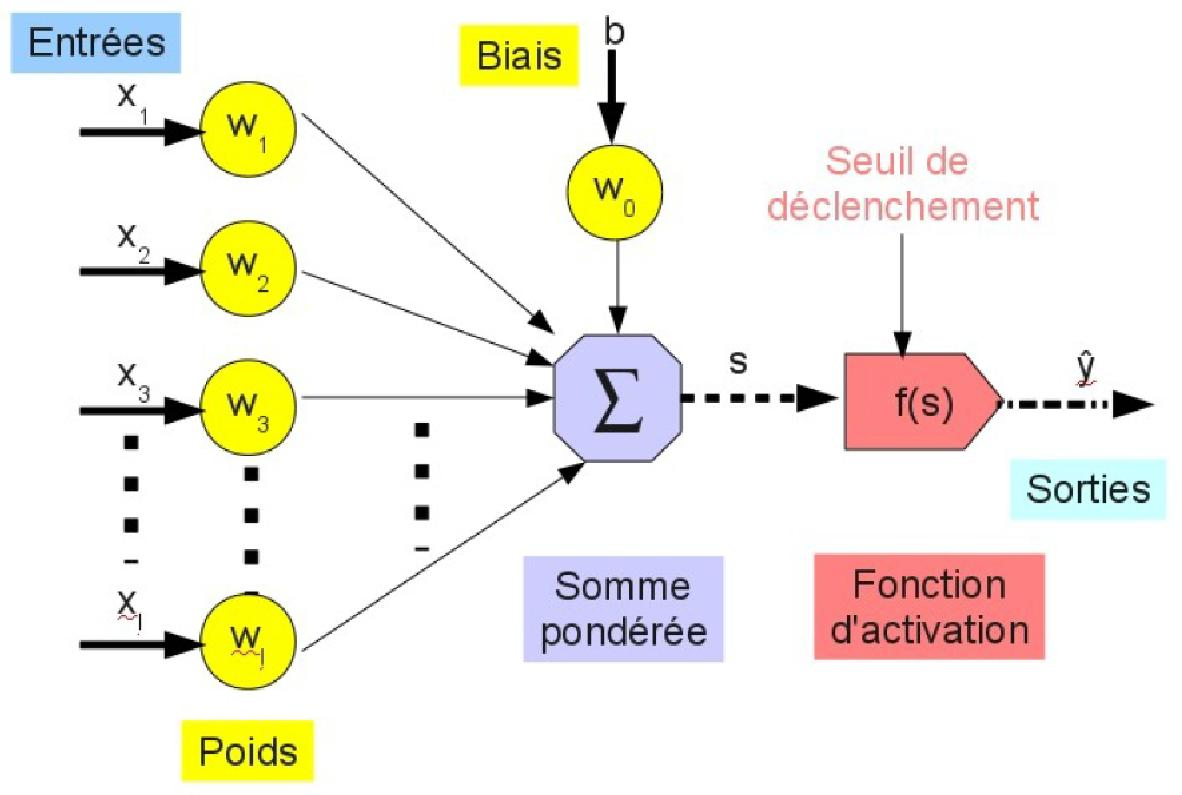

In [49]:
Image(filename='Figure01.jpg')

  On peut modéliser la réponse du neurone comme étant :
  $$ \tilde Y = sign\Big( \sum_{j=1}^d w_j x_j + b \Big) = sign(<W,X>) $$
  où $\tilde Y$ est la prédiction de classification de notre neurone, avec $W = (b,w_1,\dots w_d)$, $X=(1,x_1,\dots,x_d)$ et $<.,.>$ le produit scalaire Euclidien standard.

L'apprentissage machine  s'intéresse au problème de la minimisation d'une fonction objectif qui a la forme d'une somme :
$${\displaystyle Q(w)=\sum _{i=1}^{n}Q_{i}(w)}$$
où le paramètre $w^{*}$  qui minimise Q(w) doit être estimé.
dans ce cas, $ Q_{i}(w) $ est la valeur de la fonction objectif pour le  i-ème exemple.


Lorsqu'elle est utilisée pour minimiser cette fonction, la méthode standard de descente de gradient correspond à cette itération : $${\displaystyle w:=w - \eta \sum _{i=1}^{n}\nabla Q_{i}(w)}$$

In [50]:
import time as t
import numpy as np
import numpy.random as npr
from numpy.linalg import norm
import pandas as pd
import scipy.stats as st
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.model_selection import KFold
%matplotlib inline

Tout d'abord on va importer les données avec pandas

In [51]:
Sonar = pd.read_csv('sonar.all-data.csv', header = None)
Sonar.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


Dans ce tableau on a 208 lignes et 61 colones ,dont les lignes correspondent aux observations et les 60 colones les caractérisques(variables). La dernière colone contient les réponses Rocher(R) ou Mine(M).

Remarque: les données sont normalisées et comprisent entre 0 et 1


On entame alors la phase de préparation des données,
donc on va convertir toutes les valeurs "string" à "float64",sauf la dernière colone qui contient les réponse (restera en "string", d'où le errors = 'ignore'). 

In [52]:
n_data, n_feat = Sonar.shape
n_feat -= 1
Sonar.astype('float64', errors = 'ignore')

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,R
7,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,...,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,R
8,0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,...,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,R
9,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,R


### Création du jeu d'apprentissage

On extrait ensuite les valeurs qui nous intéresses. Pour `x_data` on prend tout le tableau sauf la dernière colonne, et pour les réponses `y_data`, on prend la dernière colonne et on transforme les 'R' de rocher en 1 et les 'M' de mine en -1.

In [53]:
values = Sonar.values

x_data = values[:,:n_feat]

y_data = np.array([1. if values[i,-1] == 'R' else -1. for i in range(n_data)])
print("type de X",type(x_data))
#print(x_data)
print("type de y",type(y_data))
#print(y_data)

type de X <class 'numpy.ndarray'>
type de y <class 'numpy.ndarray'>


### La fonction de prédiction 

In [54]:
def class_prediction(X, W): 
    return np.sign(np.dot(X, W.T))

### Phase d'entrainement

Dans cette première étape nous allons entrainer notre neurone sur des données d'entrainement, c'est à dire que nous allons chercher une estimation des poids W minimisant l'erreur de prédiction sur ces données d'entrainement

In [55]:
train_size=158
test_size=50
index=npr.permutation(208)

x_train,x_test,y_train,y_test=x_data[index[:train_size]],x_data[index[train_size:]],y_data[index[:train_size]],y_data[index[train_size:]]
X_train = np.concatenate((np.ones((train_size,1)), x_train), axis = 1) 
X_test= np.concatenate((np.ones((test_size,1)), x_test), axis = 1)

### Méthodes de réduction de dimensions

Il peut être très difficile de visualiser des jeux de données de grande dimension. Tandis que des données en deux ou trois dimensions peuvent être tracées pour montrer la structure inhérente des données, les tracés équivalents de grande dimension sont beaucoup moins intuitifs. Pour faciliter la visualisation de la structure d'un jeu de données, la dimension doit être réduite d'une manière ou d'une autre.

#### a) Analyse en composantes principales (PCA)

Méthode de réduction de dimensionnalité linéaire à l'aide de la valeur singulière, 
décomposition des données pour les projeter dans un espace dimensionnel inférieur.

In [56]:
from sklearn.decomposition import PCA
#Analyse par composante principale. C'est une méthode de réduction de la dimension.
pca = PCA(n_components=2)

x_pca = pca.fit_transform(x_train)

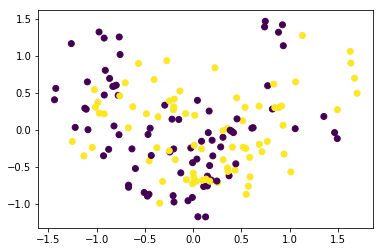

In [57]:
import matplotlib.pyplot as plt

plt.scatter(x_pca[:,0], x_pca[:,1], c=y_train)

#### b) Intégration localement linénaire (LLE)
 On recherche par cette méthode ,une projection des données de dimension inférieur qui préserve les distances au sein des quartiers locaux. 



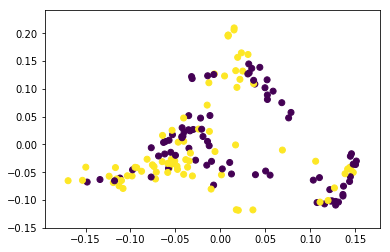

In [58]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
x_lle = lle.fit_transform(x_train)
#On regarde les plus proches voisins. On cherche une base qui permet de "conserver" les plus proches voisins de chaque point.
plt.scatter(x_lle[:,0], x_lle[:,1], c=y_train)

### reduction à 3 dimensions

In [59]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


from mpl_toolkits.mplot3d import Axes3D

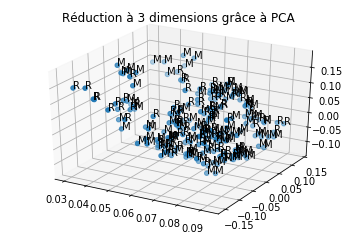

In [60]:
sonar = pd.read_csv('sonar.all-data.csv', header = None)
pca = PCA(n_components=3)
pca.fit(np.transpose(sonar.iloc[:,:60]))
result = pca.components_
#print(result)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Réduction à 3 dimensions grâce à PCA")
ax.scatter(result[0,:],result[1,:],result[2,:])

siz = len(result[0])

for i in range(siz):
    ax.text(result[0,i],result[1,i],result[2,i],sonar.iloc[i,-1])
plt.show()

On introduit maintenant des fonctions qui vont être utilisées lors de cette phase pour la descente de gradient stochastique:

On rappelle que pour le $i$-ème example la prédiction $\tilde Y_i$ est donnée par 

$$ \tilde Y_i = sign\Big( \sum_{j=1}^d w_j x_{ij} + b_i \Big) = sign(<W,X_i>) $$

####  Fonction de risque empérique pour la perception : $$ Q(W,X,Y) = \frac{1}{N}\sum_{j=1}^N (\tilde Y_i - Y_i)^2 $$

In [61]:
def Q(W, X, Y):
    return np.mean((class_prediction(X, W)-Y)**2)

#### Fonction servant à la mise à jour des poids lors des itérations de la méthode de gradient stochastique:

$$ J(W,X,Y) =  (\tilde Y - Y)*X $$

In [62]:
def J(W, X, Y):
    return (class_prediction(X, W)-Y)*X

####  Fonction de mise à jour des poids pour la méthode de la descente de gradient stochastique (SGD)

Pour tout $X$ parcourant les données ,on fait:
   
  $${\displaystyle W_{N+1} = W_{N} - \eta(\tilde Y - Y)*X},$$

où $\eta$ s'appelle le taux d'apprentissage.

In [63]:
def SGD(X, Y, W, learn_rate, n_data1):
    """ 
    fonction permettant la mise à jour
    des poids W sur un passage des données
    
    X: matrice des caractéristiques (des données) - ndarray de longueur (n_data,d+1)
    Y: réponse correspondant à l'exemple X - ndarray de longueur d+1
    W: poids - ndarray de longueur d+1
    learn_rate: taux d'apprentissage - nombre réel
    n_data: nombre d'exemple (de ligne) dans la matrice X - nombre entier
    """
    
    for i in range(n_data1):
        W = W - learn_rate*J(W, X[i,:], Y[i])
        
    return W

### Fonction qui calcule la valeur du poids W par la méthode SGD

Cette fonction prendra en argument:
- Les données d'apprentissage (les caractéristiques et réponses)
- Le taux d'apprentissage(learn_rate)
- Les nombres d'itération de SGD (appelé n_epoch)

In [64]:
def training_weight_0(X_train, Y_train, learn_rate, n_epoch):
    
    """ 
    fonction permettant la mise à jour
    des poids W sur un passage des données
    
    X_train: matrice des données d'entrainement - ndarray de longueur (n_data,d+1)
    Y_train: réponse correspondant aux exemples de X_train - ndarray de longueur d+1
    learn_rate: taux d'apprentissage - nombre réel
    n_epoch: nombre de passage sur les données pour la mise à jour des poids - nombre entier
    """
    
    n_data, n_col = X_train.shape
    # calcul de n_data
    
    W = np.zeros(n_col)
    # initialisation des poids
    
    # descente de gradient stochastique
    for _ in range(n_epoch):
        
        data_shuffle = npr.permutation(train_size) 
        # calcul d'une permutation aléatoire 
        # qu'on appliquera au ligne de X_train et Y_train 
        
        W = SGD(X_train[data_shuffle], Y_train[data_shuffle], W, learn_rate,train_size) 
        # mise à jour des poids sur un passage des données d'entrainement
      #  print(data_shuffle)
    return W

#### Fonction d'observation de l'erreur

Elle nous permet d'observer l'évolution de la convergence de l'erreur commise suivant la mise à jour des poids par la fonction SGD

In [65]:
def training_weight(X_train, Y_train, learn_rate, n_epoch):
    
    """ 
    fonction permettant la mise à jour
    des poids W sur un passage des données
    
    X_train: matrice des données d'entrainement - ndarray de longueur (n_data,d+1)
    Y_train: réponse correspondant aux exemples de X_train - ndarray de longueur d+1
    learn_rate: taux d'apprentissage - nombre réel
    n_epoch: nombre de passage sur les données pour la mise à jour des poids - nombre entier
    """
    
    n_data, n_col = X_train.shape
    # calcul de n_data
    
    W = np.zeros(n_col)
    # initialisation des poids
    
    error_rec = np.array([])
    # variable qui enregistre l'évolution de l'erreur empirique
    
    # descente de gradient stochastique
    for _ in range(n_epoch):
        
        data_shuffle = npr.permutation(n_data) 
        # calcul d'une permutation aléatoire 
        # qu'on appliquera au ligne de X_train et Y_train 
        
        W = SGD(X_train[data_shuffle], Y_train[data_shuffle], W, learn_rate, n_data) 
        # mise à jour des poids sur un passage des données d'entrainement
        
        error = Q(W, X_train, Y_train)
        # evaluation du rique avec la valeur courante des poids W
        
        error_rec = np.append(error_rec, error)
        # enregistrement de cette valeur
        #print(error)
    return W, error_rec

#### illustration de la qualité de  classification en utilisant les poids W calculés par training_weight_0


Commençons par calculer les poids qu'on va utiliser pour la classification des données d'entrainement (dont on connait le résultat). Ceci nous sert de cas test pour s'assurer du bon fonctionnement de notre code.

In [66]:
n_epoch = 50
learn_rate = 0.001

W, err_rec = training_weight(X_train, y_train, learn_rate, n_epoch)

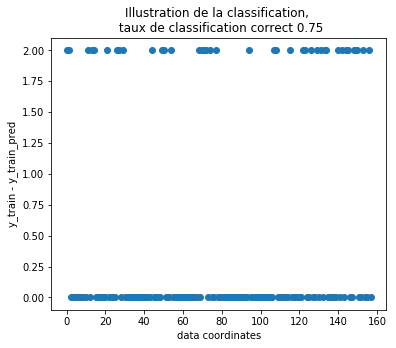

In [312]:
figsize(6,5)

y_train_pred = class_prediction(X_train, W)

# calcul du taux de classification ou aussi appelé score
classif_rate = 1-np.mean((y_train- y_train_pred !=0))
#t=np.size(y_train)
#s=np.arange(1,t+1)
#classif_rate1=t*0
#classif_rate1 = 1-np.cumsum((y_train - y_train_pred ))/s
plt.plot(y_train - y_train_pred,'o')
plt.xlabel('data coordinates')
plt.ylabel('y_train - y_train_pred')
plt.title("Illustration de la classification, \n taux de classification correct %0.2f" % classif_rate)
plt.show()

Dans la cellule précédente on calcul le score de classification sur les données d'entrainement:

$$ 1- \frac{1}{N_{train}}\sum_{j=1}^{N_{train}} \mathbf{1}_{(\tilde{Y}_{j,train}-Y_{j,train}\neq 0)}.$$

On trace l'évolution de la fonction de risque empirique

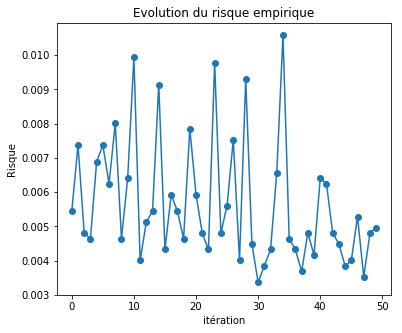

In [67]:
figsize(6,5)
#train_size +=1
risque = err_rec/train_size
plt.plot(risque,'o-')
plt.xlabel('itération')
plt.ylabel("Risque")
plt.title("Evolution du risque empirique")
plt.show()


### Généralisation

Maintenant, on va tester si notre neurone a bien été entrainé. Pour cela,on va utiliser nos données de test, et voir comment notre algorithme prédit la classification de ces nouvelles données à partir des données d'entrainement.

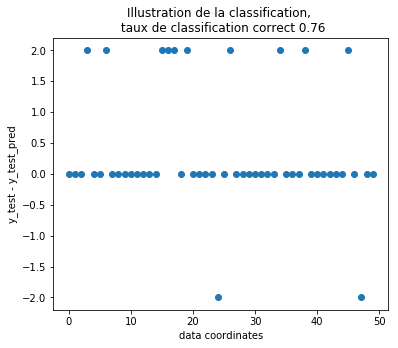

In [314]:
figsize(6,5)

y_test_pred = class_prediction(X_test, W)
# calcul prédiction de notre 

# calcul du taux de classification ou aussi appelé score
classif_rate = 1-np.mean((y_test- y_test_pred !=0))
#t=np.size(y_train)
#s=np.arange(1,t+1)
#classif_rate1=t*0
#classif_rate1 = 1-np.cumsum((y_test - y_test_pred ))/s
plt.plot(y_test - y_test_pred,'o')
plt.xlabel('data coordinates')
plt.ylabel('y_test - y_test_pred')
plt.title("Illustration de la classification, \n taux de classification correct %0.2f" % classif_rate)
plt.show()

Ce resulat obtenu (le score) pour les données test nous permet d'affirmer que notre neurone est bien entrainé

### Fonction perceptron qui résume toutes les étapees de classification des données 

 Elle prend en entré:
 - Les données d'entrainement x_train et les réponses y_train (pour entrainer le neurone)
 - Les données de test x_test et les réponses y_test (pour tester l'éfficacité du neurone)
 - Le taux d'apprentissage 
 - Le nombre d'époch pour SGD
 Cette fonction :
 - calcul le poids W à partir des données d'entrainement et leurs réponses.
 - classifie les données de test c'est à dire calculer une prédiction $\tilde{Y}_{j,test}$ pour chaque donnée de tes
 - retourne le score de classification sur les données de test
 $$ 1- \frac{1}{N_{test}}\sum_{j=1}^{N_{test}} \mathbf{1}_{(\tilde{Y}_{j,test}-Y_{j,test}\neq 0)}$$

In [315]:
def Perceptron(x_train, y_train, x_test, y_test, learn_rate, n_epoch,choix_score):
    """
    fonction Perceptron: classifie une jeu de donnés en deux groupes
    renvoi le score de classification sur les donné
    et l'envolution de la fonction de risque
    
    x_train: données d'entrainement - ndarray
    y_train: réponses pour les données d'entrainement- ndarray
    x_test: données de test- ndarray
    y_test: réponse pour les données de test- ndarray
    learn_rate: taux d'apprentissage - nombre réel
    n_epoch: nombre de passage sur les données pour la mise à jour des poids - nombre entier
    """
    
    ###### Phase d'entrainement ######
    
    n_train, _ = x_train.shape
    # calcul du nombre d'exemple dans le jeu de données d'entrainement
    
    X_train = np.concatenate((np.ones((n_train,1)), x_train), axis = 1) 
    # ajout de la colonne de 1 sur les données d'entrainement
    
    W, err_rec = training_weight(X_train, y_train, learn_rate, n_epoch)
    # entrainement des poids sur les données d'entrainement
    
    y_train_pred = class_prediction(X_train, W)
    # calcul des prédictions par notre model pour les données d'entrainement
    
    ###### Phase de test ######
    
    n_test, _ = x_test.shape
    # calcul du nombre d'exemple dans le jeu de données de test
    
    X_test = np.concatenate((np.ones((n_test,1)), x_test), axis = 1)  
    # ajout de la colonne de 1 sur les données de test
    
    y_test_pred = class_prediction(X_test, W)
    # calcul des prédictions par notre model pour les données de test
    if choix_score==1:
        score = 1-np.mean((y_train - y_train_pred !=0))
    else:
        score = 1-np.mean((y_test - y_test_pred !=0))                         
    # evaluation du score (taux de classification) sur les données de test
    
    return  score, err_rec

In [316]:
#score_test=2
#score_train=1
choix_score=2
score, err_rec = Perceptron(x_train, y_train, x_test, y_test, learn_rate, n_epoch,choix_score)

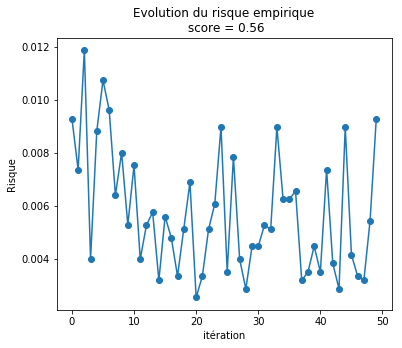

In [317]:
figsize(6,5)
risque = err_rec/train_size
plt.plot(risque,'o-')
plt.xlabel('itération')
plt.ylabel("Risque")
plt.title("Evolution du risque empirique\n score = %.2f"% score)
plt.show()

## Déscente de gradient stochastique adaptative (Adam) 

On utilise maintenant une méthode adaptative (du taux d'apprentissage) de la descente de gradient stochastique appelée Adam et dont le principe est le suivant.

Cette méthode utilise des variables auxiliaires qu'on initialisera à $0$. L'étape de mise à jour des poids sur une donnée $X$ est la suivante

- $ m_{N+1} = \beta_1* m_{N} + (1-\beta_1)(\tilde Y - Y)*X$
- $ v_{N+1} = \beta_2* v_{N} + (1-\beta_2)[(\tilde Y - Y)*X]^2$ (où le carré est pris terme à terme)
- $\hat m_{N+1} = m_{N+1}/(1-\beta_1^{N+1})$
- $\hat v_{N+1} = v_{N+1}/(1-\beta_2^{N+1})$

puis la mise à jour des poids

$$ W_{N+1} =   W_{N} - \eta \frac{\hat m_{N+1}}{\sqrt{\hat v_{N+1}}+\epsilon},$$

(où les opérations se font terme à terme). 

On prend les valeurs suivantes (qui sont les mêmes que les valeurs par défaut dans tensor flow) $\beta_1 = 0.9$, $\beta_2 = 0.999$, et $\epsilon=10^{-8}$.

On écrit une fonction Perceptron_Adam dont les poids $W$ sont caluler par la méthode Adam.


#### Fonction de la descente de gradient stochastique Adam (SGD_Adam)

In [318]:
def SDG_adam(X, Y, W, learn_rate, n_data1,M,V,t):
    Bet1 = .9
    Bet2 = .999
    e=1e-8
   #grad=J(W, X[i,:], Y[i])
    for i in range(n_data1):
        M=Bet1*M+(1-Bet1)*J(W, X[i,:], Y[i])
        V=Bet2*V+(1-Bet2)*J(W, X[i,:], Y[i])**2
        Mt=M/(1-Bet1**(t))
        Vt=V/(1-Bet2**(t))
        W = W - learn_rate*Mt/((Vt)**0.5+e)
    return W,V,M


### Fonction de mise à jour du poids W avec SDG_adam

In [319]:
def training_weight_SGD_adam(X_train, Y_train, learn_rate, n_epoch):
    
 
    
    n_data, n_col = X_train.shape
    # calcul de n_data
    
    W = np.zeros(n_col)
    M = np.zeros(n_col)
    V = np.zeros(n_col)
    # initialisation des poids
    
    error_rec = np.array([])
    # variable qui enregistre l'évolution de l'erreur empirique
    t=0
    # descente de gradient stochastique
#    while(1):
    for _ in range(n_epoch):
        t+=1
        data_shuffle = npr.permutation(n_data) 
        # calcul d'une permutation aléatoire 
        # qu'on appliquera au ligne de X_train et Y_train 
        W_0_prev=W
        W,V,M = SDG_adam(X_train[data_shuffle], Y_train[data_shuffle], W, learn_rate,n_data,M,V,t) 
        # mise à jour des poids sur un passage des données d'entrainement

        error = Q(W, X_train, Y_train)
        # evaluation du rique avec la valeur courante des poids W
        
        error_rec = np.append(error_rec, error)
        r=np.sum(np.abs(W - W_0_prev))
        # enregistrement de cette valeur
        #print(error)
#        print(r)
#        if( r==0 ):
#            break
    return W, error_rec

#### Perceptron_adam qui résume toutes les étapes 

In [320]:
def Perceptron_adam(x_train, y_train, x_test, y_test, learn_rate, n_epoch,choix_score):
  
    
    ###### Phase d'entrainement ######
    
    n_train, _ = x_train.shape
    # calcul du nombre d'exemple dans le jeu de données d'entrainement
    
    X_train = np.concatenate((np.ones((n_train,1)), x_train), axis = 1) 
    # ajout de la colonne de 1 sur les données d'entrainement
    
    W, err_rec = training_weight_SGD_adam(X_train, y_train, learn_rate, n_epoch)
    # entrainement des poids sur les données d'entrainement
    
    y_train_pred = class_prediction(X_train, W)
    # calcul des prédictions par notre model pour les données d'entrainement
    
    ###### Phase de test ######
    
    n_test, _ = x_test.shape
    # calcul du nombre d'exemple dans le jeu de données de test
    
    X_test = np.concatenate((np.ones((n_test,1)), x_test), axis = 1)  
    # ajout de la colonne de 1 sur les données de test
    
    y_test_pred = class_prediction(X_test, W)
    # calcul des prédictions par notre model pour les données de test
    if choix_score==1:
        score = 1-np.mean((y_train - y_train_pred !=0))
    else:
        score = 1-np.mean((y_test - y_test_pred !=0))
    # evaluation du score (taux de classification) sur les données de test
    
    return  score, err_rec


In [321]:
#score_test=2
#score_train=1
choix_score=2
score_adam, err_rec_adam = Perceptron_adam(x_train, y_train, x_test, y_test, learn_rate, n_epoch,choix_score)

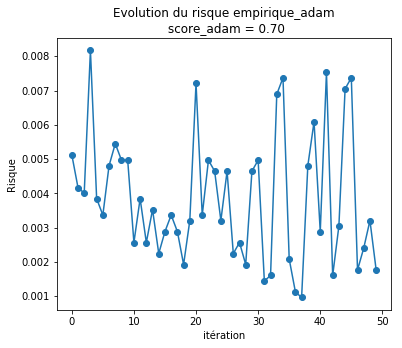

In [322]:
figsize(6,5)
risque_adam = err_rec_adam/train_size
plt.plot(risque_adam,'o-')
plt.xlabel('itération')
plt.ylabel("Risque")
plt.title("Evolution du risque empirique_adam\n score_adam = %.2f"% score_adam)
plt.show()

### Gradient accéléré de Nesterov

On utilise maintenant la méthode de gradient accéléré de nesterov dont le principe est le suivant.

Cette méthode utilise une variable auxiliaire $V_{N_{0}}$ qu'on initialisera à $0$,L'étape de mise à jour des poids sur une donnée $X$ est la suivante

- $ V_{N+1} =  \gamma V_{N} +  \eta \nabla_{W}(W_{N}- \gamma V_{N})$  (où le carré est pris terme à terme)

puis la mise à jour des poids

$$ W_{N+1} =   W_{N} - V_{N+1},$$


#### Fonction de gradient stochastique Nesterov (SDG_nesterov)

In [323]:
def SDG_nesterov(X, Y, W, learn_rate, n_data1,V):
    gamma = .9

#    grad=J(W, X[i,:], Y[i])
    for i in range(n_data1):
        V=gamma*V+learn_rate*J(W-gamma*V, X[i,:], Y[i])
        W = W -V
    return W,V

### Fonction de mise à jour du poids W avec SDG_nesterov

In [324]:
def training_weight_nesterov(X_train, Y_train, learn_rate, n_epoch):
    
 
    
    n_data, n_col = X_train.shape
    # calcul de n_data
    
    W = np.zeros(n_col)
    V = np.zeros(n_col)
    # initialisation des poids
    
    error_rec = np.array([])
    # variable qui enregistre l'évolution de l'erreur empirique
    t=0
    # descente de gradient stochastique

    for _ in range(n_epoch):
        
        data_shuffle = npr.permutation(n_data) 
        # calcul d'une permutation aléatoire 
        # qu'on appliquera au ligne de X_train et Y_train 
        W_0_prev=W
        W,V= SDG_nesterov(X_train[data_shuffle], Y_train[data_shuffle], W, learn_rate,n_data,V) 
        # mise à jour des poids sur un passage des données d'entrainement

        error = Q(W, X_train, Y_train)
        # evaluation du rique avec la valeur courante des poids W
        
        error_rec = np.append(error_rec, error)
        r=np.sum(np.abs(W - W_0_prev))
        # enregistrement de cette valeur
 
    return W, error_rec

#### Perceptron_nesterov qui résume toutes les étapes 

In [325]:
def Perceptron_nesterov(x_train, y_train, x_test, y_test, learn_rate, n_epoch,choix_score):
  
    
    ###### Phase d'entrainement ######
    
    n_train, _ = x_train.shape
    # calcul du nombre d'exemple dans le jeu de données d'entrainement
    
    X_train = np.concatenate((np.ones((n_train,1)), x_train), axis = 1) 
    # ajout de la colonne de 1 sur les données d'entrainement
    
    W, err_rec = training_weight_nesterov(X_train, y_train, learn_rate, n_epoch)
    # entrainement des poids sur les données d'entrainement
    
    y_train_pred = class_prediction(X_train, W)
    # calcul des prédictions par notre model pour les données d'entrainement
    
    ###### Phase de test ######
    
    n_test, _ = x_test.shape
    # calcul du nombre d'exemple dans le jeu de données de test
    
    X_test = np.concatenate((np.ones((n_test,1)), x_test), axis = 1)  
    # ajout de la colonne de 1 sur les données de test
    
    y_test_pred = class_prediction(X_test, W)
    # calcul des prédictions par notre model pour les données de test
    if choix_score==1:
        score = 1-np.mean((y_train - y_train_pred !=0))
    else:
        score = 1-np.mean((y_test - y_test_pred !=0))
    # evaluation du score (taux de classification) sur les données de test
    
    return  score, err_rec


In [326]:
#score_test=2
#score_train=1
choix_score=2
score_nesterov, err_rec_nesterov = Perceptron_nesterov(x_train, y_train, x_test, y_test, learn_rate, n_epoch,choix_score)

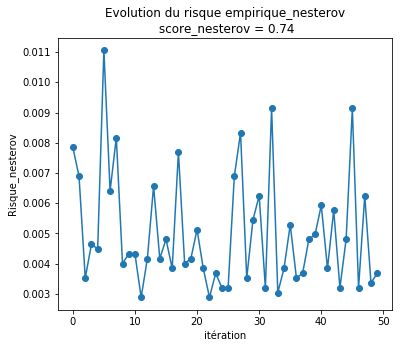

In [327]:
figsize(6,5)
risque_nesterov = err_rec_nesterov/train_size
plt.plot(risque_nesterov,'o-')
plt.xlabel('itération')
plt.ylabel("Risque_nesterov")
plt.title("Evolution du risque empirique_nesterov\n score_nesterov = %.2f"% score_nesterov)
plt.show()

### b) k folds cross validation (validation croisée)

Cette méthode permet d'évaluer les performances de notre modèle, et consiste à découper les données disponibles en deux sous parties (de manière aléatoire mais dans des proportions pré-définies), une partie qui servira à l'entrainement et une partie au test de généralisation. Bien entendu pour ce jeu de donnée on connait les vraies réponses et on peut tester le score de classification. Ensuite on recommence ces étapes $k$ fois et on regarde le score moyen obtenu et la variance de ces scores. 

La fonction `KFold` du sous module `sklearn.model_selection` permet de faire automatiquement ce découpage.

In [328]:
from sklearn.model_selection import KFold

Ci-dessous on demande 3 répétitions, et on demande aussi que les données soient mélangé aléatoirement à chaque répétition

In [329]:
kf = KFold(n_splits=3, shuffle=True)

On fait le test

score moyen = 0.69, std = 0.04


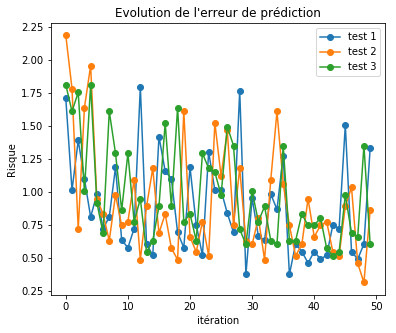

In [330]:
score_eval = []

error = []

#for train_index, test_index in kf.split(X_train):
    
   # x_train1, x_test = x_train[train_index], x_train[test_index]
   # Y_train, Y_test = y_train[train_index], y_train[test_index]
    
   # score, err_rec = Perceptron(x_train1, Y_train, x_test, Y_test, learn_rate, n_epoch)
    
   # score_eval.append(score)
   # error.append(err_rec)
for train_index, test_index in kf.split(x_data):
    
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    score, err_rec = Perceptron(x_train, y_train, x_test, y_test, learn_rate, n_epoch,choix_score)
    
    score_eval.append(score)
    error.append(err_rec)
    
print("score moyen = %0.2f, std = %0.2f" % (np.mean(score_eval),np.std(score_eval)))

for j, err in enumerate(error):
    plt.plot(err,'o-', label = 'test {}'.format(j+1))
plt.legend()    
plt.xlabel('itération')
plt.ylabel("Risque")
plt.title("Evolution de l'erreur de prédiction")
plt.show()
    

#### Fonction d'évaluation d'erreur

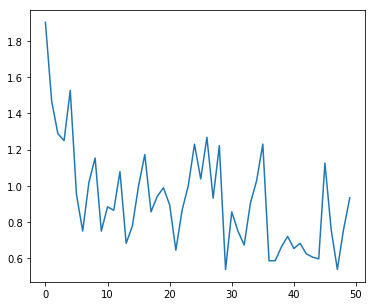

In [331]:
Moy = np.mean(np.array(error), axis=0)
plt.plot(Moy)
plt.show()

## Comparaison des trois méthodes avec la validation croisée

In [342]:
score_eval = []

error = []

score_eval_adam = []

error_adam = []

score_eval_nesterov = []

error_nesterov = []
n_epoch1=43

#for train_index, test_index in kf.split(X_train):
    
   # x_train1, x_test = x_train[train_index], x_train[test_index]
   # Y_train, Y_test = y_train[train_index], y_train[test_index]
    
   # score, err_rec = Perceptron(x_train1, Y_train, x_test, Y_test, learn_rate, n_epoch)
    
   # score_eval.append(score)
   # error.append(err_rec)
for train_index, test_index in kf.split(x_data):
    
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    score1, err_rec1 = Perceptron(x_train, y_train, x_test, y_test, learn_rate, n_epoch1,chiox_score)
    score2, err_rec2 = Perceptron_adam(x_train, y_train, x_test, y_test, learn_rate, n_epoch1,chiox_score)
    score3, err_rec3 = Perceptron(x_train, y_train, x_test, y_test, learn_rate, n_epoch1,chiox_score)
    score_eval.append(score1)
    error.append(err_rec1)
    score_eval_adam.append(score2)
    error_adam.append(err_rec2)
    score_eval_nesterov.append(score3)
    error_nesterov.append(err_rec3)

le score moyen pour la méthode Perceptron est:  0.759427240816
le score moyen pour la méthode Perceptron_Adam est:  0.851040906405
le score moyen pour la méthode Perceptron_nesterov est:  0.800611684565


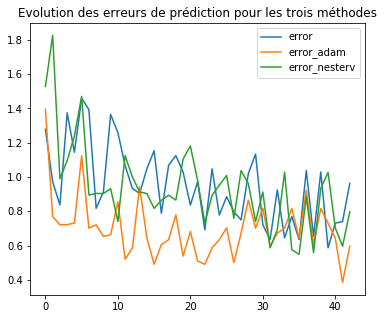

In [343]:
print("le score moyen pour la méthode Perceptron est: ", np.mean(score_eval,axis=0))
print("le score moyen pour la méthode Perceptron_Adam est: ", np.mean(score_eval_adam,axis=0))
print("le score moyen pour la méthode Perceptron_nesterov est: ", np.mean(score_eval_nesterov,axis=0))
Moy1 = np.mean(np.array(error), axis=0)
Moy2 = np.mean(np.array(error_adam), axis=0)
Moy3 = np.mean(np.array(error_nesterov), axis=0)
plt.plot(Moy1)
plt.plot(Moy2)
plt.plot(Moy3)
plt.legend(['error','error_adam','error_nesterv'])
plt.title("Evolution des erreurs de prédiction pour les trois méthodes")
plt.show()

## Conclusion

La méthode de perceptron_adam est le meilleur car il a le score le plus élevé
